## Project: Wrangle, Assess & Visualize WeRateDogs Twitter Archive

### Author: Ben Farrell
### Date: 02/05/2020

## Table of Contents
<ol>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#tweepy">Twitter API</a></li>
    <li><a href="#Gather">Gathering</a></li>
    <ol type='i'>
        <li><a href="#Local">Local File</a></li>
        <li><a href="#URL">Download .tsv form URL</a></li>
        <li><a href="#Tweepy">Download Data from Twitter API</a></li>
    </ol>
    <li><a href="#Assess">Assessing</a></li>
    <li><a href="#Clean">Cleaning</a></li>
        <ol type='1'>
        <li><a>5.1 Remove Retweets</a></li>
        <li><a>5.2 Remove Replies</a></li>
        <li><a>5.3 Change timestamp to DateTime</a></li>
        <li><a>5.4 Extract correct scores</a></li>
        <li><a>5.5 Missing URLS</a></li>
        <li><a>5.6 Dog Stages over Multiple Columns </a></li>
        <li><a>5.7 Incorrect Names extracted</a></li>
        <li><a>5.8 Join neural network and identify bread</a></li>
        <li><a>5.9 Drop unused columns</a></li>
        <li><a>5.10 Join Twitter data and remove entries with missing values</a></li>
        <li><a>5.11 Drop all entries which are not dogs</a></li>
        </ol>
    <li><a href="#Save">Save Final DataFrame to CSV</a></li>
    <li><a href="#eda">Exploratory Data Analysis</a></li>
    <li><a href="#ref">References</a></li>  
</ol>

<a id="intro"></a>
### 1. Introduction

**The aim of the Project was to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.**

Details about WeRateDogs

Dog stage (i.e. doggo, floofer, pupper, and puppo)
doggo - older sufisticated dog
puppo - Teen dog
pupper - young dog

blep - tongue hanging out the mouth
snoot - dogs nose
floof - fluffy dogs

Notes
- We are only interested in original ratings that have images
    - ONLY DOGS
    - NO RETWEETS
- Wrangling
    - 8 quality issues
    - 2 tidiness issues

- No data past 01/08/2017



In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tweepy
import requests
import os
import urllib
import json
import math

<a id="tweepy"></a>
### 2. Twitter API

In [3]:
#Saved creditials for Tweepy
ids = {}
with open('twitterAPI.txt','r') as file:
    for line in file.readlines():
        k = line.split(':')[0]
        v = line.split(':')[1][:-1]
        ids[k] = v

In [4]:
#Access API
auth = tweepy.OAuthHandler(ids['consumer_key'], ids['consumer_secret'])
auth.set_access_token(ids['access_token'], ids['access_token_secret'])
api = tweepy.API(auth, 
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)


<a id="Gather"></a>
### 3. Gathering

<a id='Local'></a>
#### 3.A Local File

In [5]:
# Open and check basic data
df = pd.read_csv('twitter-archive-enhanced.csv')
df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [7]:
#Unique tweet_id
df.tweet_id.nunique()

2356

In [8]:
#Check cwd to ensure saving file in correct location
cdir = os.getcwd()
cdir

'/Users/benfarrell/Documents/Udacity/DataAnalyst/P4_Wrangling'

<a id='URL'></a>
#### 3.B Download .tsv form URL

In [9]:
# Url for tweet image predictions
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
# File name
file = url.split('/')[-1]
# Combine directory and file name for save
save = cdir+'/'+file

In [10]:
#Download image prediction data
urllib.request.urlretrieve(url,save)

('/Users/benfarrell/Documents/Udacity/DataAnalyst/P4_Wrangling/image-predictions.tsv',
 <http.client.HTTPMessage at 0x116618f40>)

In [11]:
# Check image prediction data
df2 = pd.read_csv('image-predictions.tsv',sep='\t')
df2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
# Unique tweet ids
df2.tweet_id.nunique()

2075

<a id='Tweepy'></a>
#### 3.C Download Data from Twitter API

In [21]:
s_list = []
count = 1
for t_id in list(df.tweet_id):
    try:
        print(f'Count: {count}')
        status = api.get_status(t_id,tweet_mode='extended')
        s_list.append(status)
    except Exception as e:
        print(f'{t_id} Failed, Count: {count}')
    
    count+=1

Count: 1
Count: 2
Count: 3
Count: 4
Count: 5
Count: 6
Count: 7
Count: 8
Count: 9
Count: 10
Count: 11
Count: 12
Count: 13
Count: 14
Count: 15
Count: 16
Count: 17
Count: 18
Count: 19
Count: 20
888202515573088257 Failed, Count: 20
Count: 21
Count: 22
Count: 23
Count: 24
Count: 25
Count: 26
Count: 27
Count: 28
Count: 29
Count: 30
Count: 31
Count: 32
Count: 33
Count: 34
Count: 35
Count: 36
Count: 37
Count: 38
Count: 39
Count: 40
Count: 41
Count: 42
Count: 43
Count: 44
Count: 45
Count: 46
Count: 47
Count: 48
Count: 49
Count: 50
Count: 51
Count: 52
Count: 53
Count: 54
Count: 55
Count: 56
Count: 57
Count: 58
Count: 59
Count: 60
Count: 61
Count: 62
Count: 63
Count: 64
Count: 65
Count: 66
Count: 67
Count: 68
Count: 69
Count: 70
Count: 71
Count: 72
Count: 73
Count: 74
Count: 75
Count: 76
Count: 77
Count: 78
Count: 79
Count: 80
Count: 81
Count: 82
Count: 83
Count: 84
Count: 85
Count: 86
Count: 87
Count: 88
Count: 89
Count: 90
Count: 91
Count: 92
Count: 93
Count: 94
Count: 95
Count: 96
873697596434

Count: 694
Count: 695
Count: 696
Count: 697
Count: 698
Count: 699
Count: 700
Count: 701
Count: 702
Count: 703
Count: 704
Count: 705
Count: 706
Count: 707
Count: 708
Count: 709
Count: 710
Count: 711
Count: 712
Count: 713
Count: 714
Count: 715
Count: 716
Count: 717
Count: 718
Count: 719
Count: 720
Count: 721
Count: 722
Count: 723
Count: 724
Count: 725
Count: 726
Count: 727
Count: 728
Count: 729
Count: 730
Count: 731
Count: 732
Count: 733
Count: 734
Count: 735
Count: 736
Count: 737
Count: 738
Count: 739
Count: 740
Count: 741
Count: 742
Count: 743
Count: 744
Count: 745
Count: 746
Count: 747
Count: 748
Count: 749
Count: 750
Count: 751
779123168116150273 Failed, Count: 751
Count: 752
Count: 753
Count: 754
Count: 755
Count: 756
Count: 757
Count: 758
Count: 759
Count: 760
Count: 761
Count: 762
Count: 763
Count: 764
Count: 765
Count: 766
Count: 767
Count: 768
Count: 769
Count: 770
Count: 771
Count: 772
Count: 773
Count: 774
Count: 775
Count: 776
Count: 777
Count: 778
Count: 779
Count: 780
Count

Rate limit reached. Sleeping for: 704


Count: 902
Count: 903
Count: 904
Count: 905
Count: 906
Count: 907
Count: 908
Count: 909
Count: 910
Count: 911
Count: 912
Count: 913
Count: 914
Count: 915
Count: 916
Count: 917
Count: 918
Count: 919
Count: 920
Count: 921
Count: 922
Count: 923
Count: 924
Count: 925
Count: 926
Count: 927
Count: 928
Count: 929
Count: 930
Count: 931
Count: 932
Count: 933
754011816964026368 Failed, Count: 933
Count: 934
Count: 935
Count: 936
Count: 937
Count: 938
Count: 939
Count: 940
Count: 941
Count: 942
Count: 943
Count: 944
Count: 945
Count: 946
Count: 947
Count: 948
Count: 949
Count: 950
Count: 951
Count: 952
Count: 953
Count: 954
Count: 955
Count: 956
Count: 957
Count: 958
Count: 959
Count: 960
Count: 961
Count: 962
Count: 963
Count: 964
Count: 965
Count: 966
Count: 967
Count: 968
Count: 969
Count: 970
Count: 971
Count: 972
Count: 973
Count: 974
Count: 975
Count: 976
Count: 977
Count: 978
Count: 979
Count: 980
Count: 981
Count: 982
Count: 983
Count: 984
Count: 985
Count: 986
Count: 987
Count: 988
Count

Count: 1590
Count: 1591
Count: 1592
Count: 1593
Count: 1594
Count: 1595
Count: 1596
Count: 1597
Count: 1598
Count: 1599
Count: 1600
Count: 1601
Count: 1602
Count: 1603
Count: 1604
Count: 1605
Count: 1606
Count: 1607
Count: 1608
Count: 1609
Count: 1610
Count: 1611
Count: 1612
Count: 1613
Count: 1614
Count: 1615
Count: 1616
Count: 1617
Count: 1618
Count: 1619
Count: 1620
Count: 1621
Count: 1622
Count: 1623
Count: 1624
Count: 1625
Count: 1626
Count: 1627
Count: 1628
Count: 1629
Count: 1630
Count: 1631
Count: 1632
Count: 1633
Count: 1634
Count: 1635
Count: 1636
Count: 1637
Count: 1638
Count: 1639
Count: 1640
Count: 1641
Count: 1642
Count: 1643
Count: 1644
Count: 1645
Count: 1646
Count: 1647
Count: 1648
Count: 1649
Count: 1650
Count: 1651
Count: 1652
Count: 1653
Count: 1654
Count: 1655
Count: 1656
Count: 1657
Count: 1658
Count: 1659
Count: 1660
Count: 1661
Count: 1662
Count: 1663
Count: 1664
Count: 1665
Count: 1666
Count: 1667
Count: 1668
Count: 1669
Count: 1670
Count: 1671
Count: 1672
Coun

Rate limit reached. Sleeping for: 704


Count: 1801
Count: 1802
Count: 1803
Count: 1804
Count: 1805
Count: 1806
Count: 1807
Count: 1808
Count: 1809
Count: 1810
Count: 1811
Count: 1812
Count: 1813
Count: 1814
Count: 1815
Count: 1816
Count: 1817
Count: 1818
Count: 1819
Count: 1820
Count: 1821
Count: 1822
Count: 1823
Count: 1824
Count: 1825
Count: 1826
Count: 1827
Count: 1828
Count: 1829
Count: 1830
Count: 1831
Count: 1832
Count: 1833
Count: 1834
Count: 1835
Count: 1836
Count: 1837
Count: 1838
Count: 1839
Count: 1840
Count: 1841
Count: 1842
Count: 1843
Count: 1844
Count: 1845
Count: 1846
Count: 1847
Count: 1848
Count: 1849
Count: 1850
Count: 1851
Count: 1852
Count: 1853
Count: 1854
Count: 1855
Count: 1856
Count: 1857
Count: 1858
Count: 1859
Count: 1860
Count: 1861
Count: 1862
Count: 1863
Count: 1864
Count: 1865
Count: 1866
Count: 1867
Count: 1868
Count: 1869
Count: 1870
Count: 1871
Count: 1872
Count: 1873
Count: 1874
Count: 1875
Count: 1876
Count: 1877
Count: 1878
Count: 1879
Count: 1880
Count: 1881
Count: 1882
Count: 1883
Coun

In [22]:
with open('tweet_json.txt','w',encoding='utf-8') as file:
    for item in s_list:
        json.dump(item._json,file)
        file.write('\n')

In [14]:
tweet_list = []
with open('tweet_json.txt','r') as file:
    for line in file.readlines():
        #convert tweet data into dict
        tweet = json.loads(line)
        #Create dict to store extracted data
        tweet_dict = {}
        tweet_dict['tweet_id'] = tweet['id']
        tweet_dict['retweets'] = tweet['retweet_count']
        tweet_dict['favorite'] = tweet['favorite_count']
        #Add dictionary to list
        tweet_list.append(tweet_dict)

In [15]:
df3 = pd.DataFrame(tweet_list)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   tweet_id  2331 non-null   int64
 1   retweets  2331 non-null   int64
 2   favorite  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


<a id="Assess"></a>
### 4. Assessing

Review the data first to spot issues

In [16]:
# Local file - Enhanced Twitter Archive
df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [18]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [19]:
#No repeated data/duplicates
df.tweet_id.nunique()

2356

In [22]:
# Incorrect name 
df[df.apply(lambda x: len(x['name']) == 1,axis=1)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
775,776201521193218049,NaN,NaN,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776201521...,10,10,O,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,8,10,a,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a carrot. We only rate dogs. Please on...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746872823...,11,10,a,None,None,None,None
1049,743222593470234624,NaN,NaN,2016-06-15 23:24:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a very rare Great Alaskan Bush Pupper....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593...,12,10,a,None,None,pupper,None
1193,717537687239008257,NaN,NaN,2016-04-06 02:21:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",People please. This is a Deadly Mediterranean ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717537687...,11,10,a,None,None,None,None
1207,715733265223708672,NaN,NaN,2016-04-01 02:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a taco. We only rate dogs. Please only...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715733265...,10,10,a,None,None,None,None


**Quality**

Local File - Enhance Twitter Archive

<ol>
    <li>Remove data from retweets</li>
    <li>Remove data from replies to retweets</li>
    <li>Timestamp stored as object - Should be Datetime</li>
    <li>Numerators below 8 and greater than 15 to be investigated</li>
    <ol>
        <li>Plagarism - idx 315</li>
        <li>No dogs present in photo idx 1016</li>
        <li>wrong score extracted from text e.g idx 45, tweet_id: 883482846933004288, correct value 13.5, recorded value 5</li>
        <li>not a dog tweet_id: 670842764863651840</li>
    </ol>
    <li>Denominator not equal to 10 shoudl be investigated e.g: idx 313</li>
    <li>Scores extracted incorrectly, don't account for decimals</li>
    <li>Names are sometime extracted incorrectly</li>
    <li>Expanded_URLS missing data: 59 entries missing</li>
    <li>Expanded_URLS duplicate URL data</li>
    <li>Missing data in doggo, floofer, pupper, puppo are categories of dog. Only 380 entries have a category</li>
    <li>Use neural network image data to remove all non dog tweets</li>
    
</ol>
     
**Tidiness**
<ol>
    <li>doggo, floofer, pupper, puppo are categories of dog. Data should be in one column, titled category</li>
    <li>Only original tweets should be used. Use retweet data to filter any retweet entries from data</li>
    <li>Combine 3 datasets on tweet_id into one dataset</li>
</ol>

<a id="Clean"></a>
### 5 Cleaning

In [23]:
#Makes copies of each dataset
df_clean = df.copy()
df2_clean = df2.copy()
df3_clean = df3.copy()

#### 5.1.1 Definition: Present data continues entries from Retweets.
Only interested in original tweets. So any entry which has Retweet data must be removed.

#### 5.1.2 Clean: Remove Retweet Data

In [24]:
#Filter out all entries that are not original tweets
#Retweet all have data associated with retweets
df_clean = df_clean[df_clean['retweeted_status_id'].isnull()]

In [25]:
#Drop unnecessary columns on retweet data
df_clean.drop(columns=['retweeted_status_id',
                       'retweeted_status_user_id',
                       'retweeted_status_timestamp'],
              inplace=True)

##### 5.1.3 Test: Check Retweet Data Removed

In [26]:
#Use info to show that those columns and and rows have been removed
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ 

#### 5.2.1 Definition: Present data continues entries from replies to tweets.
Only interested in original tweets. So any entry which has Retweet data must be removed.

#### 5.2.2 Clean: Remove Reply Data

In [27]:
#Filter out all entries that are replies to original tweets
#Replies all have data associated with replies
df_clean = df_clean[df_clean['in_reply_to_status_id'].isnull()]
df_clean.drop(columns=['in_reply_to_status_id',
                       'in_reply_to_user_id'],
              inplace=True)

##### 5.2.3 Test: Check Reply Data Removed

In [28]:
#Use info to show that those columns and and rows have been removed
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


#### 5.3.1 Definition:  Convert timestamp to DateTime.
Time saved as str. Should be datetime.

#### 5.3.2 Clean: Convert timestamp to DateTime.

In [29]:
#Convert timestamp into datatime from object
df_clean['timestamp'] = pd.to_datetime(df['timestamp'])

#### 5.3.3 Test: Check DateTime stored correctly


In [30]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

#### 5.4.1 Definition:  Check that correct data has been stripped out for scores
Score with decimal point are potentially being missed or extracted incorrectly. This was evident when spot checking the data.

#### 5.4.2 Clean: Use REGEX to extract score effectively.

In [31]:
#Check that correct data has been stripped out for scores
results = df_clean['text'].str.extract(r'(?P<Rating>(\d+|(\d+\.\d*))/\d+)')
results.drop(columns=[1,2],axis=1,inplace=True)
results[['Num','Den']] = results['Rating'].str.split('/',expand=True)
results = results.astype({'Num':'float64','Den':'float64'})

#### 5.4.3 Test: Check scores appear reasonable

In [32]:
#Update scores in dataset
df_clean['rating_numerator'] = results['Num']
df_clean['rating_denominator'] = results['Den']

#### 5.5.1 Definition:  Missing expanded urls
Missing URLs don't allow the image to be verified. These need to be removed from dataset

#### 5.5.2 Clean: Filter out entries with missing URLs which don't have a photo to perform evaluation on

In [33]:
#Check missing expanded urls
#After checking these 3 entries, it is clear that no photo is posted, so these will be dropped from dataset
df_clean[df_clean['expanded_urls'].isnull()]
df_clean = df_clean[df_clean['expanded_urls'].notnull()]

#### 5.5.3 Test: Make sure no missing entries remain for URLs

In [34]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   float64            
 6   rating_denominator  2094 non-null   float64            
 7   name                2094 non-null   object             
 8   doggo               2094 non-null   object             
 9   floofer             2094 non-null   object             
 10  pupper              2094 non-null   object             
 11  puppo               2094 non-null   object             
dtypes: datetime64[ns, UTC](1), float64

#### 5.6.1 Definition:  Dog Stage Split over several columns.
Some rows have multiple dog stages. Combine all the stages into a single column.

#### 5.6.2 Clean: Combine dog stage data into one column

In [35]:
#Set None values in various columns to np.nan
df_clean[['doggo','floofer','pupper','puppo']] = df_clean[['doggo','floofer','pupper','puppo']].replace('None',np.nan)

In [36]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   float64            
 6   rating_denominator  2094 non-null   float64            
 7   name                2094 non-null   object             
 8   doggo               83 non-null     object             
 9   floofer             10 non-null     object             
 10  pupper              229 non-null    object             
 11  puppo               24 non-null     object             
dtypes: datetime64[ns, UTC](1), float64

In [37]:
#Combined DogStages
df_clean['DogStage'] =df_clean[['doggo','floofer','pupper','puppo']].apply(lambda x: ','.join(x.dropna()),axis=1)

In [38]:
#Check that combined column has worked
df_clean['DogStage'].replace('',np.nan, inplace=True)
df_clean['DogStage'].value_counts()

pupper           220
doggo             72
puppo             23
doggo,pupper       9
floofer            9
doggo,floofer      1
doggo,puppo        1
Name: DogStage, dtype: int64

In [39]:
#Remove unnecessary columns
df_clean.drop(columns=['doggo','floofer','pupper','puppo'],inplace=True)

#### 5.6.3 Test: Check Combined dogStage data is in one column, also check other columns removed

In [40]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   float64            
 6   rating_denominator  2094 non-null   float64            
 7   name                2094 non-null   object             
 8   DogStage            335 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(5)
memory usage: 163.6+ KB


#### 5.7.1 Definition:  Check for incorrect name data.
Some rows have incorrect name data. This is likely due to there not being a name in the text but the initial search has pulled data anyway. This can be resolved by search and removing names with single letter e.g "a" or most that start with a lower case such as 'very' or 'an'.

#### 5.7.2 Clean: Name series of DataFrame

In [41]:
#Check for incorrect names extraced
# Some posts don't have a name, so that isn't an issue, but the 'a' values should be changed to None
df_clean.name.value_counts()

None        600
a            55
Charlie      11
Lucy         11
Oliver       10
           ... 
Norman        1
Trigger       1
Pupcasso      1
Pippin        1
Ralpher       1
Name: name, Length: 955, dtype: int64

In [42]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   float64            
 6   rating_denominator  2094 non-null   float64            
 7   name                2094 non-null   object             
 8   DogStage            335 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(5)
memory usage: 163.6+ KB


In [56]:
#Lets see all names which are either length 1 or start with lower case
odd_names = {}
for n in df_clean['name'].values:
    if n[0].islower() or len(n) == 1:
        if odd_names.get(n,0) >= 1:           
            odd_names[n] += 1
        else:
            odd_names[n] = 1

odd_names

{'such': 1,
 'a': 55,
 'quite': 3,
 'not': 2,
 'one': 4,
 'incredibly': 1,
 'O': 1,
 'very': 4,
 'my': 1,
 'his': 1,
 'an': 6,
 'actually': 2,
 'just': 3,
 'getting': 2,
 'mad': 1,
 'this': 1,
 'unacceptable': 1,
 'all': 1,
 'old': 1,
 'infuriating': 1,
 'the': 8,
 'by': 1,
 'officially': 1,
 'life': 1,
 'light': 1,
 'space': 1}

In [57]:
#As the above odd_names shows, all those values which started with a lower case letter should not be recorded as names
#Function to catch and change names which begin with lower case letter such as 'a'.
def sortName(row):
    if row['name'][0].islower() or row['name'] == 'None':
        return np.nan
    else:
        return row['name']

In [58]:
df_clean['name']=df_clean.apply(sortName,axis=1)

#### 5.7.3 Test: Check names series of DataFrame

In [59]:
#The value coutns series looks to have many erronous values removed "None" and 'a' etc
df_clean['name'].value_counts()

Charlie     11
Lucy        11
Cooper      10
Oliver      10
Penny        9
            ..
Jay          1
Norman       1
Trigger      1
Pupcasso     1
Ralpher      1
Name: name, Length: 929, dtype: int64

In [60]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   float64            
 6   rating_denominator  2094 non-null   float64            
 7   name                1390 non-null   object             
 8   DogStage            335 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(5)
memory usage: 163.6+ KB


In [61]:
#Lets check for remaining names which are of lenght 1
df_clean.loc[df_clean['name'].str.len() == 1]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,DogStage
775,776201521193218049,2016-09-14 23:30:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,https://twitter.com/dog_rates/status/776201521...,10.0,10.0,O,NaN


In [62]:
#Rename single value which has stripped out name incorrectly
df_clean.loc[775,'name'] = 'O\'Malley'

In [63]:
#Check name substituted
df_clean.loc[775,'name']

"O'Malley"

In [64]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   float64            
 6   rating_denominator  2094 non-null   float64            
 7   name                1390 non-null   object             
 8   DogStage            335 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(5)
memory usage: 243.6+ KB


#### 5.8.1 Definition:  Join in neural network data 
Neural network data will provide valuable insights into identifiying dog breads. This is currently in another dataframe. This needs to be merged. After that it will be used to identify dog breads and will also help remove no dog data from the table. This will be done in conjuction with the WeRateDogs Rating.

#### 5.8.2 Clean: Merge nerual network datafram on tweet_id

In [91]:
#Join neural network data
df_clean = pd.merge(df_clean,df2_clean,on=['tweet_id'],how='left')

In [93]:
#Use logic of neural network and ratings to determine if there is a dog in photo
# If the neural network predicts no dog and rating is low, we will assume no dog present
def dogPrediction(row):
    if row['rating_numerator'] >= 7:
        if row['p1_dog'] == True:
            return row['p1']
        elif row['p2_dog'] == True:
            return row['p2']
        elif row['p3_dog'] == True:
            return row['p3']
        else:
            return 'Unknown'
    else:
        return 'No_Dog'    

In [94]:
df_clean['Dog_Prediction'] = df_clean.apply(dogPrediction,axis=1)

#### 5.8.3 Clean: Merge nerual network dataframe on tweet_id and create series which identified dog bread

In [97]:
df_clean.Dog_Prediction.value_counts()

Unknown                 358
golden_retriever        156
No_Dog                  115
Labrador_retriever      104
Pembroke                 91
                       ... 
Scotch_terrier            1
silky_terrier             1
Irish_wolfhound           1
Bouvier_des_Flandres      1
clumber                   1
Name: Dog_Prediction, Length: 114, dtype: int64

#### 5.9.1 Definition:  Drop unwanted columns of data
A number of columns will no longer be requires for analysis. This includes the source, and P1,P2,P3 values from neural data. The most likely dog prediction has now been extracted from that data. 

#### 5.9.2 Clean: Remove columns (series) which are deemed to no longer be of use.

In [69]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   float64            
 6   rating_denominator  2094 non-null   float64            
 7   name                1390 non-null   object             
 8   DogStage            335 non-null    object             
 9   jpg_url             1971 non-null   object             
 10  img_num             1971 non-null   float64            
 11  p1                  1971 non-null   object             
 12  p1_conf             1971 non-null 

In [70]:
df_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1962
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       30
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [71]:
#Remove data
col = ['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog','source']
df_clean.drop(columns=col,inplace=True)

#### 5.9.3 Test: Check columns (series) which are deemed to no longer be of use have been deleted

In [72]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   text                2094 non-null   object             
 3   expanded_urls       2094 non-null   object             
 4   rating_numerator    2094 non-null   float64            
 5   rating_denominator  2094 non-null   float64            
 6   name                1390 non-null   object             
 7   DogStage            335 non-null    object             
 8   jpg_url             1971 non-null   object             
 9   img_num             1971 non-null   float64            
 10  Dog_Prediction      2094 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(6)
memory usage: 196.3+ KB


#### 5.10.1 Definition:  Join in Data obtained from Twitter API
Data from likes and retweets was missing from original data. This was acquired from Tweepy API. This needs to be merged 

#### 5.10.2 Clean: Join and check data from Tweepy

In [73]:
#Merge in likes and favourites data
df_clean = pd.merge(df_clean,df3_clean,on=['tweet_id'],how='left')

In [74]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   text                2094 non-null   object             
 3   expanded_urls       2094 non-null   object             
 4   rating_numerator    2094 non-null   float64            
 5   rating_denominator  2094 non-null   float64            
 6   name                1390 non-null   object             
 7   DogStage            335 non-null    object             
 8   jpg_url             1971 non-null   object             
 9   img_num             1971 non-null   float64            
 10  Dog_Prediction      2094 non-null   object             
 11  retweets            2087 non-null   float64            
 12  favorite            2087 non-null 

In [76]:
#From the downloaded data, 7 tweets appear to have been removed. These will be dropped from the dataset
df_clean = df_clean[df_clean['retweets'].notnull()]

#### 5.10.3 Test: Check Tweepy Data has been imported correctly and null values have been omitted

In [77]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 0 to 2093
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2087 non-null   int64              
 1   timestamp           2087 non-null   datetime64[ns, UTC]
 2   text                2087 non-null   object             
 3   expanded_urls       2087 non-null   object             
 4   rating_numerator    2087 non-null   float64            
 5   rating_denominator  2087 non-null   float64            
 6   name                1383 non-null   object             
 7   DogStage            334 non-null    object             
 8   jpg_url             1964 non-null   object             
 9   img_num             1964 non-null   float64            
 10  Dog_Prediction      2087 non-null   object             
 11  retweets            2087 non-null   float64            
 12  favorite            2087 non-null 

#### 5.11.1 Definition:  Drop all entreis that are not thought to be dogs
At the start of this analysis, it was an objective to only evaluate dogs. Therefore no dog data should be removed.

#### 5.11.2 Clean: Removing no dog data
This will be done by using the Dog_Prediction series. Any with a rating of No_Dog will be removed

In [78]:
#Drop all entries which are believed to not be dogs
df_final = df_clean[df_clean['Dog_Prediction'] != 'No_Dog']

#### 5.11.3 Test; Need to check that No_Dog data has been removed.

In [79]:
df_final[df_final['Dog_Prediction'] == 'No_Dog']

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,DogStage,jpg_url,img_num,Dog_Prediction,retweets,favorite


In [80]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1972 entries, 0 to 2093
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1972 non-null   int64              
 1   timestamp           1972 non-null   datetime64[ns, UTC]
 2   text                1972 non-null   object             
 3   expanded_urls       1972 non-null   object             
 4   rating_numerator    1972 non-null   float64            
 5   rating_denominator  1972 non-null   float64            
 6   name                1335 non-null   object             
 7   DogStage            330 non-null    object             
 8   jpg_url             1850 non-null   object             
 9   img_num             1850 non-null   float64            
 10  Dog_Prediction      1972 non-null   object             
 11  retweets            1972 non-null   float64            
 12  favorite            1972 non-null 

<a id='save'></a>
### 6. Save Final Clean DataFrame to CSV

In [81]:
#Save the final DataFrame to a csv file name twitter_archive_master.csv
df_final.to_csv('twitter_archive_master.csv',index=False)

<a id="eda"></a>
### 7.0 Exploratory Data Analysis

In [82]:
#What is the most common dog type on WeRateDogs?
df_final.Dog_Prediction.value_counts()

Unknown                 358
golden_retriever        156
Labrador_retriever      104
Pembroke                 91
Chihuahua                87
                       ... 
Scotch_terrier            1
silky_terrier             1
Irish_wolfhound           1
Bouvier_des_Flandres      1
clumber                   1
Name: Dog_Prediction, Length: 113, dtype: int64

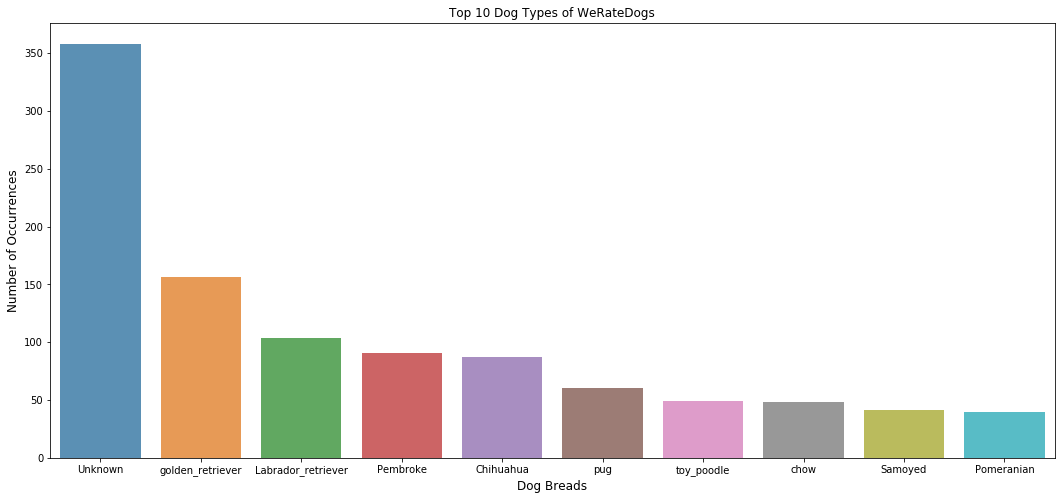

In [83]:
# Top 10
dog_types = df_final.Dog_Prediction.value_counts()[:]
dog_types = dog_types[:10,]
plt.figure(figsize=(18,8))
sns.barplot(dog_types.index, dog_types.values, alpha=0.8)
plt.title('Top 10 Dog Types of WeRateDogs')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Dog Breads', fontsize=12)
plt.show()

In [84]:
df_final['rating_numerator']

0       13.0
1       13.0
2       12.0
3       13.0
4       12.0
        ... 
2086    10.0
2088    10.0
2091     9.0
2092     7.0
2093     8.0
Name: rating_numerator, Length: 1972, dtype: float64

In [85]:
#Which bread of dog receives the highest/lowest average rating?
df_final['Rating'] = df_final.apply(lambda x: x['rating_numerator']/x['rating_denominator'],axis=1)

<ipython-input-85-0b677a7d8dd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Rating'] = df_final.apply(lambda x: x['rating_numerator']/x['rating_denominator'],axis=1)


In [86]:
df_final['Rating'].groupby(df_final['Dog_Prediction']).mean().sort_values(ascending=False)

Dog_Prediction
Unknown                   1.696089
Afghan_hound              1.300000
Bouvier_des_Flandres      1.300000
Saluki                    1.250000
briard                    1.233333
                            ...   
redbone                   0.966667
Welsh_springer_spaniel    0.950000
Tibetan_terrier           0.925000
Ibizan_hound              0.925000
Scotch_terrier            0.900000
Name: Rating, Length: 113, dtype: float64

In [87]:
df_final['Rating'].groupby(df_final['Dog_Prediction']).mean().sort_values(ascending=True)

Dog_Prediction
Scotch_terrier            0.900000
Ibizan_hound              0.925000
Tibetan_terrier           0.925000
Welsh_springer_spaniel    0.950000
redbone                   0.966667
                            ...   
briard                    1.233333
Saluki                    1.250000
Bouvier_des_Flandres      1.300000
Afghan_hound              1.300000
Unknown                   1.696089
Name: Rating, Length: 113, dtype: float64


Ignoring the unknown categories of dogs, the Afghan_Hound scores on average the highest with a rating of 1.3 (13/10)

The lowest scoring bread of dog on average is the Scotch_Terrier with an average score of 0.9 (9/10)

In [88]:
#Which bread of dog on average receives the most likes?
df_final['favorite'].groupby(df_final['Dog_Prediction']).mean().sort_values(ascending=False)

Dog_Prediction
Bedlington_terrier       24450.600000
Saluki                   22272.750000
Afghan_hound             20521.500000
French_bulldog           18787.866667
flat-coated_retriever    17542.857143
                             ...     
standard_schnauzer        1855.000000
Tibetan_terrier           1681.750000
Irish_wolfhound           1392.000000
groenendael               1055.500000
Brabancon_griffon          807.000000
Name: favorite, Length: 113, dtype: float64

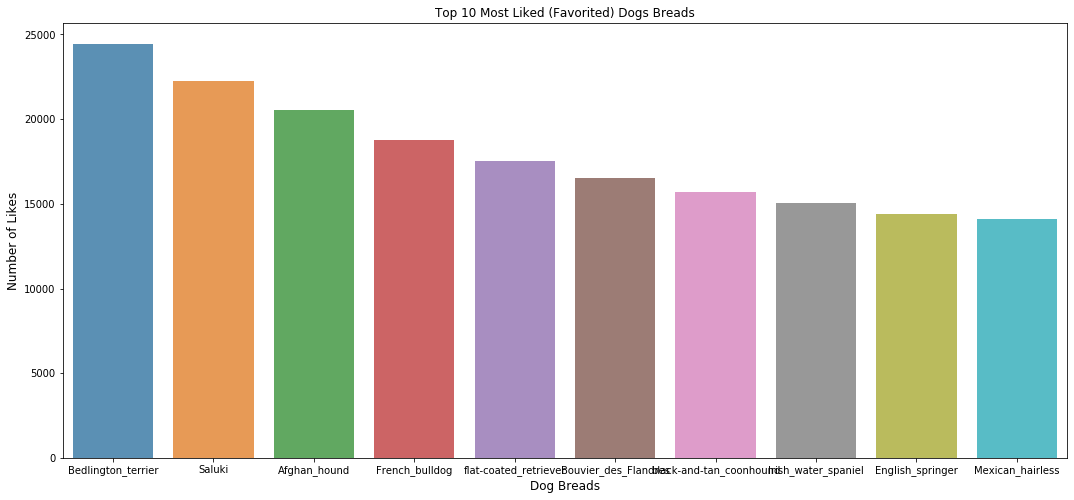

In [89]:
# Top 10
dog_types = df_final['favorite'].groupby(df_final['Dog_Prediction']).mean().sort_values(ascending=False)
dog_types = dog_types[:10,]
plt.figure(figsize=(18,8))
sns.barplot(dog_types.index, dog_types.values, alpha=0.8)
plt.title('Top 10 Most Liked (Favorited) Dogs Breads')
plt.ylabel('Number of Likes', fontsize=12)
plt.xlabel('Dog Breads', fontsize=12)
plt.show()

<a id="ref"></a>
### References

1. https://developer.twitter.com/en/docs/